# GEOS 505: Problem Set 3

### Background:

As part of your thesis, you are using a physics-based model to predict how the timing and amount of snow water storage in the Boise River Basin will change under alternative future scenarios of swe_time_seriesate. You have your model up and running and presented preliminary results for the first time at a recent committee meeting. One of your committee members works with the Idaho NRCS snow survey and points out that your results would be more impactful if you could present them in the context of historical observations of snow water equivalent (SWE). In particular, your committee wants you to plot your simulations on top of historical SNOTEL swe_time_seriesatology, presented as follows: 

<img src="../img/trinity_mtn-id-wteq-por.png" alt="Trinity Mtn. SNOTEL" width="1000" style="display: block; margin: 0 auto"/>

This figure, which can be generated on the NRCS website for any SNOTEL site and many water supply basins. This particular image is the 30 year "normals" for the 1991-2020 timeframe at Trinity Mountain SNOTEL site in the Upper Boise. The plot contains a water-year oriented plot of the following items:

- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

### Problem: 

Your hypothetical task for your thesis and the task for this problem set is to reproduce the above figure in a way that would allow you to analyze and plot historical data at a variety of SNOTEL sites, and in a way that would allow you to plot the corresponding version of this plot with simulated data for a future swe_time_seriesate. As such, the expected outcome of this notebook is code that produces an image that looks similar to the above. You may certainly use an alternative color scheme, but make sure that the elements of the plot are labeled.

The outline of the steps is provided below, along with some helpful suggestions of `numpy` and `matplotlib` functions that you will likely need.

### 1. Imports and Definitions

In [2]:
from datetime import datetime
from dataretrieval import nwis
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [3]:
startDate = '1985-10-01'
endDate = '2025-09-30'

startDate_dt = datetime.strptime(startDate, '%Y-%m-%d')
endDate_dt = datetime.strptime(endDate, '%Y-%m-%d')

# Metloom Variables
snotel_stn = '830:ID:SNTL' # Trinity Mountain Snotel Station
snotel_pnt = SnotelPointData(station_id=snotel_stn, name='TrinityMtn')

variables = [snotel_pnt.ALLOWED_VARIABLES.SWE]

### 2. Load the Data and Verify

In [4]:
df_snotel = snotel_pnt.get_daily_data(startDate_dt, endDate_dt, variables)

In [5]:
# Plot data to check it out
df_snotel.reset_index(level='site', inplace=True)
#df_snotel['SWE'].plot(title='Trinity Mountain SNOTEL SWE Time Series', ylabel='SWE (inches)', xlabel='Date', figsize=(12,6))
#plt.show()

In [6]:
nYears = (endDate_dt.year - startDate_dt.year) + 1

### 3. Prep Data and Preallocate Storage

In [ ]:
swe_time_series = np.zeros((nYears, 365))

### 4. Analyze Data

In [9]:
# make the date index timezone aware
df_snotel.index = df_snotel.index.tz_localize(None)
df_snotel = df_snotel.sort_index()

# create a new column of months starting on the water year
df_snotel['water_year'] = df_snotel.index.to_series().apply(
    lambda d: d.year + 1 if d.month >= 10 else d.year
)

# create a series that starts on water year
wy_start = pd.to_datetime(df_snotel['water_year'] - 1, format='%Y') + pd.Timedelta(days=273)
# column of days that aligns with start of water year
df_snotel['dowy'] = (df_snotel.index - wy_start).dt.days + 1

# pivot the dateframe so columns are years and index is day of the water
pivot_wy = df_snotel.pivot(index='dowy', columns='water_year', values='SWE')
pivot_wy = pivot_wy.loc[1:365]      # make index strictly 1–365

swe_time_series = pivot_wy
median_swe = swe_time_series.median(axis=1)
median_peak_swe = median_swe.iloc[183] # median SWE on April 1

swe_min = swe_time_series.min(axis=1).values
q20 = swe_time_series.quantile(0.2, axis=1).values
q40 = swe_time_series.quantile(0.4, axis=1).values
q60 = swe_time_series.quantile(0.6, axis=1).values
q80 = swe_time_series.quantile(0.8, axis=1).values
swe_max = swe_time_series.max(axis=1).values

dowy = pivot_wy.index.values   # ensures all arrays align

### 5. Create Plot

Note: Here is a link to a list of named colors in matplotlib: https://matplotlib.org/stable/gallery/color/named_colors.html. 

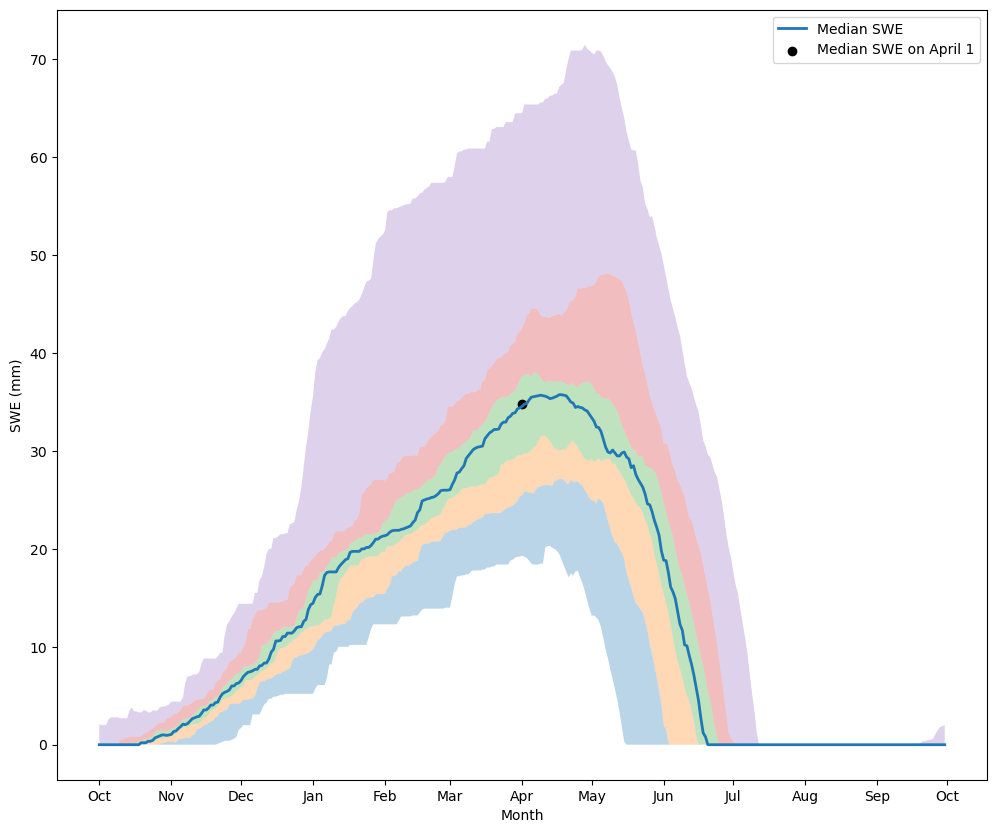

In [11]:


# Create a synthetic datetime index for the x-axis
# Choose an arbitrary water-year start (e.g., Oct 1, 2000)
synthetic_dates = pd.to_datetime("2000-10-01") + pd.to_timedelta(dowy - 1, unit="D")
# get the index for April 1
idx = (synthetic_dates.month == 4) & (synthetic_dates.day == 1)
target_date = synthetic_dates[idx][0]

# Use the synthetic dates for plotting instead of raw DOWY
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(synthetic_dates, median_swe.values, lw=2, label='Median SWE')


ax.fill_between(synthetic_dates, swe_min, q20, alpha=0.3)
ax.fill_between(synthetic_dates, q20, q40, alpha=0.3)
ax.fill_between(synthetic_dates, q40, q60, alpha=0.3)
ax.fill_between(synthetic_dates, q60, q80, alpha=0.3)
ax.fill_between(synthetic_dates, q80, swe_max, alpha=0.3)

ax.scatter(target_date, median_peak_swe, color='k', label='Median SWE on April 1')

# --- x-axis formatting: months ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Optionally rotate labels
plt.setp(ax.get_xticklabels(), rotation=0)

ax.set_xlabel("Month")
ax.set_ylabel("SWE (mm)")
ax.legend()


### Extra Code

In [ ]:
dt_range = pd.date_range(startDate_dt,endDate_dt, freq='MS')
months = dt_range.month.values

In [ ]:
# extra
df_snotel['year'] = df_snotel.index.year
df_snotel['day'] = df_snotel.index.dayofyear
#months[dt_range.month >= 9] = months[dt_range.month >= 9] + 1

pivot = df_snotel.pivot(index='day', columns='year', values='SWE')
pivot = pivot.loc[pivot.index <= 365]
pivot = pivot[sorted(pivot.columns)]
swe_time_series = pivot.to_numpy().T

In [ ]:
swe_max = np.max(swe_time_series,axis=0)
swe_min = np.min(swe_time_series,axis=0)
q20 = np.nanpercentile(swe_time_series, 20, axis=0)
q40 = np.nanpercentile(swe_time_series, 40, axis=0)
q60 = np.nanpercentile(swe_time_series, 60, axis=0)
q80 = np.nanpercentile(swe_time_series, 80, axis=0)

In [ ]:
# plots as expected - needs the fill between
# Ensure datetime index is timezone-naive
df_snotel.index = df_snotel.index.tz_localize(None)
df_snotel = df_snotel.sort_index()

# Define water year (starts Oct 1)
df_snotel['water_year'] = df_snotel.index.to_series().apply(
    lambda d: d.year + 1 if d.month >= 10 else d.year
)

# Compute day of water year (1–365)
wy_start = pd.to_datetime(df_snotel['water_year'] - 1, format='%Y') + pd.Timedelta(days=273)
df_snotel['dowy'] = (df_snotel.index - wy_start).dt.days + 1

# Pivot by water year and day of water year
pivot_wy = df_snotel.pivot(index='dowy', columns='water_year', values='SWE')
pivot_wy = pivot_wy.loc[(pivot_wy.index >= 1) & (pivot_wy.index <= 365)]
full_index = np.arange(1, 366)
pivot_wy = pivot_wy.reindex(full_index)
swe_time_series = pivot_wy.to_numpy().T

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(days,pivot_wy[2024].values, label='current WY')
ax.fill_between(days,swe_min,q20) 
ax.fill_between(days,q20,q40)
ax.fill_between(days,q20,q60)
ax.fill_between(days,q60,q80)
ax.fill_between(days,q80,swe_max)


#plt.plot(pivot_wy.index, pivot_wy.to_numpy(), alpha=0.7)
#plt.xlabel("Day of Water Year (starting Oct 1)")
#plt.ylabel("SWE")
#plt.title("Daily SWE Time Series by Water Year")
#plt.legend(pivot_wy.columns, title="Water Year", bbox_to_anchor=(1.05, 1), loc="upper left")
#plt.tight_layout()
plt.show()


In [ ]:
# extra - plotting
fig, ax = plt.subplots(figsize=(12,10))

# current WY
ax.plot(dowy, median_swe.values, linewidth=2, label='Median SWE')

# swe_time_series ribbons (correctly aligned)
ax.fill_between(dowy, swe_min, q20, alpha=0.3)
ax.fill_between(dowy, q20, q40, alpha=0.3)
ax.fill_between(dowy, q40, q60, alpha=0.3)
ax.fill_between(dowy, q60, q80, alpha=0.3)
ax.fill_between(dowy, q80, swe_max, alpha=0.3)

ax.set_xlim(1, 365)
ax.set_xlabel("Day of Water Year")
ax.set_ylabel("SWE (mm)")